#Read data

In [1]:
#!pip install kaggle
!kaggle datasets download sachinkumar413/covid-pneumonia-normal-chest-xray-images

Dataset URL: https://www.kaggle.com/datasets/sachinkumar413/covid-pneumonia-normal-chest-xray-images
License(s): copyright-authors
 99% 276M/277M [00:10<00:00, 26.9MB/s]
100% 277M/277M [00:10<00:00, 28.1MB/s]


In [2]:
import zipfile

import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [3]:
from tensorflow import keras
from keras.utils import to_categorical
from keras import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout

In [4]:
with zipfile.ZipFile('covid-pneumonia-normal-chest-xray-images.zip', 'r') as zip_ref:
    zip_ref.extractall('covid-pneumonia-normal-chest-xray-images')

#!ls covid-pneumonia-normal-chest-xray-images/COVID

In [5]:
# Read images and labels

image_path = 'covid-pneumonia-normal-chest-xray-images'
categories = ['COVID', 'NORMAL', 'PNEUMONIA']

x = []
y = []


for label, category in enumerate(categories):

  folder_path = os.path.join(image_path, category)

  for filename in os.listdir(folder_path):
    if filename.endswith('.png'):
      img_path = os.path.join(folder_path, filename)
      img = cv2.imread(img_path)
      img = cv2.resize(img, (64, 64))
      img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
      x.append(img)
      y.append(label)

x = np.array(x)
y = np.array(y)

print("Images shape:", x.shape)
print("Labels shape:", y.shape)

Images shape: (5228, 64, 64)
Labels shape: (5228,)


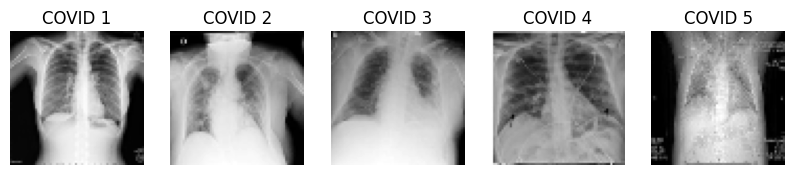

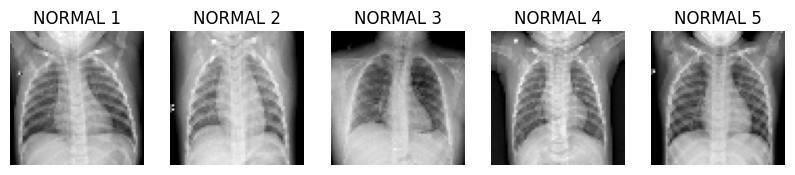

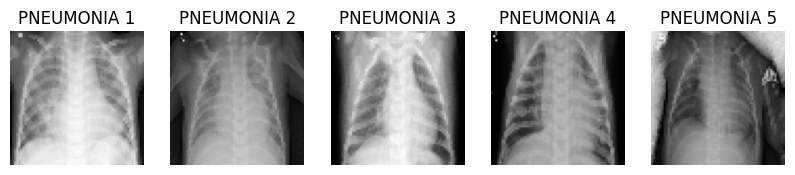

In [6]:
for category_idx, category in enumerate(categories):
  count = 0

  plt.figure(figsize=(10, 5))

  for i in range(len(y)):
    if y[i] == category_idx and count < 5:
      plt.subplot(1, 5, count+1)
      plt.imshow(x[i], cmap='gray')
      plt.title(f"{category} {count+1}")
      plt.axis('off')
      count += 1

    if count == 5:
      break

plt.show()

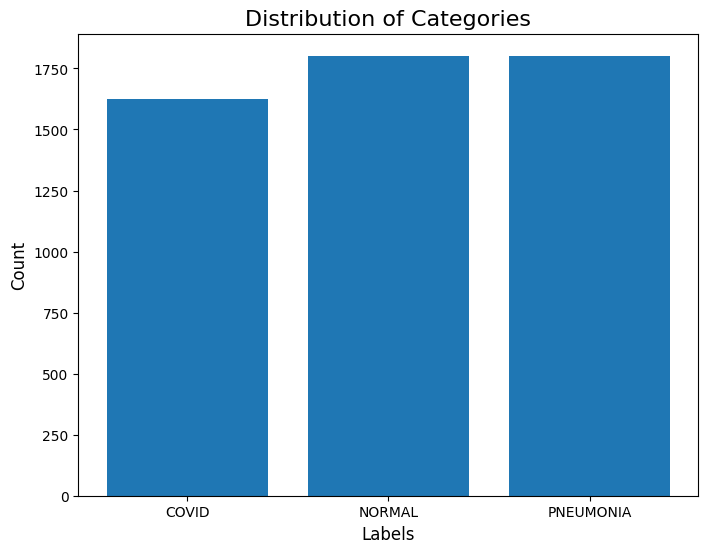

In [7]:
unique, counts = np.unique(y, return_counts=True)

plt.figure(figsize=(8, 6))
plt.bar(categories, counts)
plt.title("Distribution of Categories", fontsize=16)
plt.xlabel("Labels", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.show()

#Convolutional Neural Network

In [8]:
x_reshape = np.expand_dims(x, axis=-1)
print("Images shape:", x_reshape.shape)

Images shape: (5228, 64, 64, 1)


In [9]:
x_train, x_test, y_train, y_test = train_test_split(x_reshape, y, test_size=0.2, random_state=42, stratify=y)

print("Training data shape:", x_train.shape)
print("Training labels shape:", y_train.shape)
print("Test data shape:", x_test.shape)
print("Test labels shape:", y_test.shape)

Training data shape: (4182, 64, 64, 1)
Training labels shape: (4182,)
Test data shape: (1046, 64, 64, 1)
Test labels shape: (1046,)


In [10]:
# scale data
x_train = x_train / 255.0
x_test = x_test / 255.0

# one-hot encoding
y_train_onehot = to_categorical(y_train)
y_test_onehot = to_categorical(y_test)

In [11]:
def show_train_history(train_history, train, validation):
  plt.plot(train_history.history[train])
  plt.plot(train_history.history[validation])
  plt.title('Train History')
  plt.ylabel(train)
  plt.xlabel('Epoch')
  plt.legend(['train','validation'],loc='upper left')
  plt.show()

In [12]:
# define CNN

keras.utils.set_random_seed(123)

model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(64, 64, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(3, activation='softmax'))

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 64, 64, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 32, 32, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │         262,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 3)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 355,427 (1.36 MB)

 Trainable params: 355,427 (1.36 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
105/105 - 32s - 309ms/step - accuracy: 0.6756 - loss: 0.6950 - val_accuracy: 0.8351 - val_loss: 0.3799
Epoch 2/10
105/105 - 42s - 401ms/step - accuracy: 0.8589 - loss: 0.3806 - val_accuracy: 0.8949 - val_loss: 0.2632
Epoch 3/10
105/105 - 54s - 510ms/step - accuracy: 0.9031 - loss: 0.2838 - val_accuracy: 0.9247 - val_loss: 0.2163
Epoch 4/10
105/105 - 70s - 671ms/step - accuracy: 0.9193 - loss: 0.2399 - val_accuracy: 0.9223 - val_loss: 0.2125
Epoch 5/10
105/105 - 40s - 382ms/step - accuracy: 0.9235 - loss: 0.2338 - val_accuracy: 0.9415 - val_loss: 0.1751
Epoch 6/10
105/105 - 31s - 293ms/step - accuracy: 0.9378 - loss: 0.1883 - val_accuracy: 0.9367 - val_loss: 0.1741
Epoch 7/10
105/105 - 48s - 461ms/step - accuracy: 0.9447 - loss: 0.1595 - val_accuracy: 0.9510 - val_loss: 0.1591
Epoch 8/10
105/105 - 33s - 311ms/step - accuracy: 0.9546 - loss: 0.1431 - val_accuracy: 0.9474 - val_loss: 0.1633
Epoch 9/10
105/105 - 30s - 287ms/step - accuracy: 0.9575 - loss: 0.1416 - val_accuracy: 

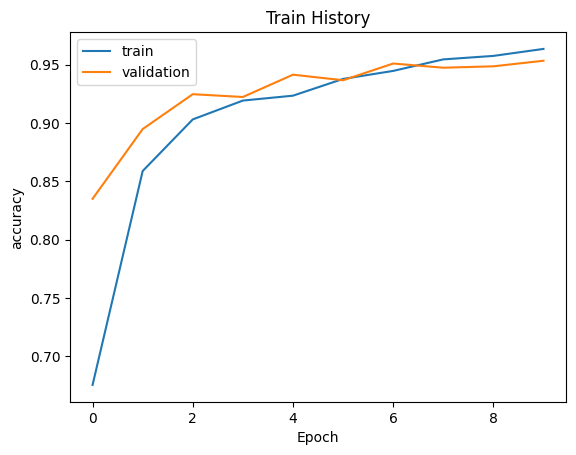

In [13]:
# train the model

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

train_history = model.fit(x=x_train, y=y_train_onehot, validation_split=0.2, epochs=10, batch_size=32, verbose=2)

show_train_history(train_history, 'accuracy', 'val_accuracy')

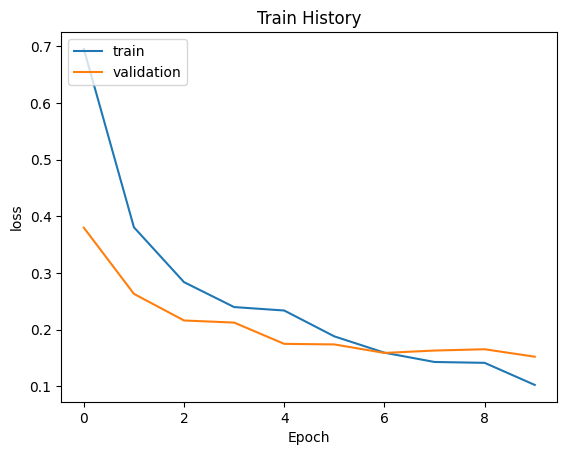

In [14]:
show_train_history(train_history, 'loss', 'val_loss')

33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step - accuracy: 0.9566 - loss: 0.1646
0.9598470330238342
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step


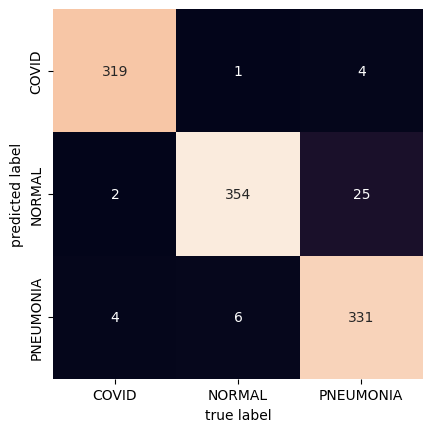

              precision    recall  f1-score   support

       COVID       0.98      0.98      0.98       325
      NORMAL       0.93      0.98      0.95       361
   PNEUMONIA       0.97      0.92      0.94       360

    accuracy                           0.96      1046
   macro avg       0.96      0.96      0.96      1046
weighted avg       0.96      0.96      0.96      1046



In [15]:
# evaluate the model

scores = model.evaluate(x_test, y_test_onehot)
print(scores[1])

prediction = np.argmax(model.predict(x_test), axis=-1)

mat = confusion_matrix(y_test, prediction)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, xticklabels=categories, yticklabels=categories)
plt.xlabel('true label')
plt.ylabel('predicted label');
plt.show()
print(classification_report(y_test, prediction, target_names=categories))

In [16]:
acc_nn = accuracy_score(y_test, prediction)
print("Accuracy:", acc_nn)

Accuracy: 0.9598470363288719


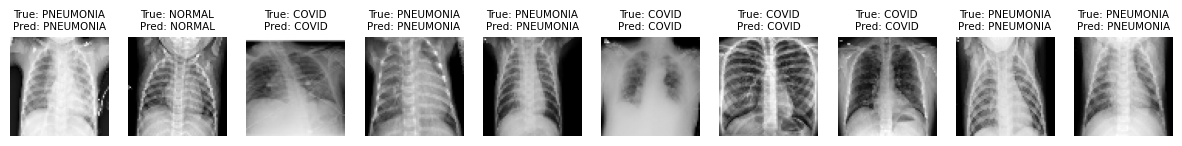

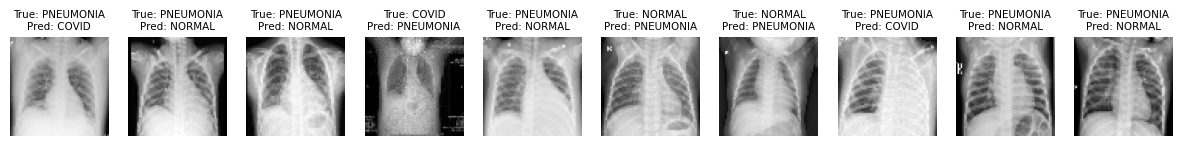

In [17]:
n_images = 10

def plot_images(images, labels, predictions, num_images=5):
  plt.figure(figsize=(15, 5))
  for i in range(num_images):
    plt.subplot(1, num_images, i+1)
    plt.imshow(images[i].squeeze(), cmap='gray')
    plt.title(f"True: {categories[labels[i]]}\nPred: {categories[predictions[i]]}", fontsize=7.5)
    plt.axis('off')
  plt.show()

correct_indices = np.where(prediction == y_test)[0]
plot_images(x_test[correct_indices[0:n_images]], y_test[correct_indices[0:n_images]], prediction[correct_indices[:n_images]], n_images)

incorrect_indices = np.where(prediction != y_test)[0]
plot_images(x_test[incorrect_indices[0:n_images]], y_test[incorrect_indices[0:n_images]], prediction[incorrect_indices[:n_images]], n_images)


#Support Vector Machine

In [18]:
Xtrain, Xtest, ytrain, ytest = train_test_split(x_reshape, y, test_size=0.2, random_state=42, stratify=y)

In [19]:
n_samples, height, width, channels = Xtrain.shape
Xtrain_flat = Xtrain.reshape(n_samples, height * width * channels)
Xtest_flat = Xtest.reshape(Xtest.shape[0], height * width * channels)

scaler = StandardScaler()
Xtrain_scaled = scaler.fit_transform(Xtrain_flat)
Xtest_scaled = scaler.transform(Xtest_flat)

print("Training data shape:", Xtrain_scaled.shape)
print("Training labels shape:", ytrain.shape)
print("Test data shape:", Xtest_scaled.shape)
print("Test labels shape:", ytest.shape)

Training data shape: (4182, 4096)
Training labels shape: (4182,)
Test data shape: (1046, 4096)
Test labels shape: (1046,)


In [20]:
pca = PCA(n_components=150, whiten=True, svd_solver='randomized', random_state=42)
svc = SVC(kernel='rbf', class_weight='balanced')
model = make_pipeline(pca, svc)

param_grid = {'svc__C': [1, 5, 10, 50], 'svc__gamma': [0.0001, 0.0005, 0.001, 0.005]}
grid = GridSearchCV(model, param_grid)
grid.fit(Xtrain_scaled, ytrain)
print("Best parameters:", grid.best_params_)

model = grid.best_estimator_
yfit = model.predict(Xtest_scaled)

/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best parameters: {'svc__C': 10, 'svc__gamma': 0.005}


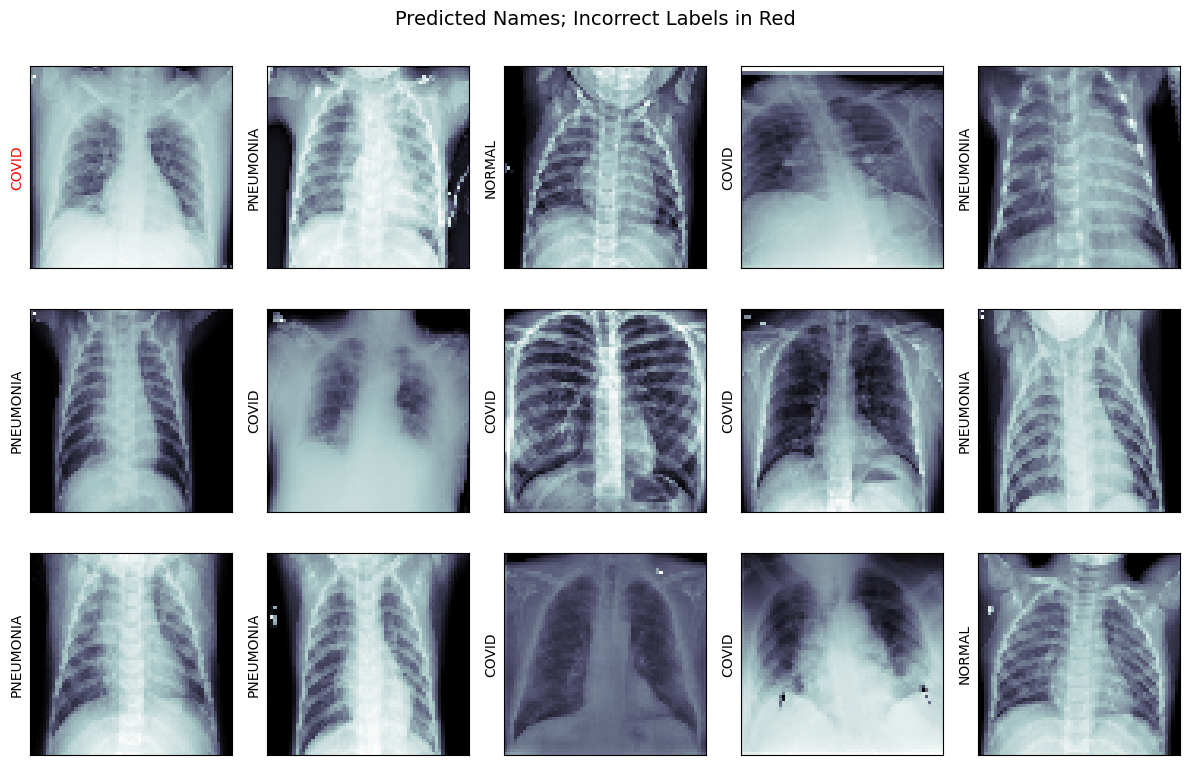

In [21]:
fig, ax = plt.subplots(3, 5, figsize=(12, 8))
for i, axi in enumerate(ax.flat):
    axi.imshow(Xtest[i].reshape(64, 64), cmap='bone')
    axi.set(xticks=[], yticks=[])
    axi.set_ylabel(categories[yfit[i]], color='black' if yfit[i] == ytest[i] else 'red')

fig.suptitle('Predicted Names; Incorrect Labels in Red', size=14)
plt.tight_layout()
plt.show()


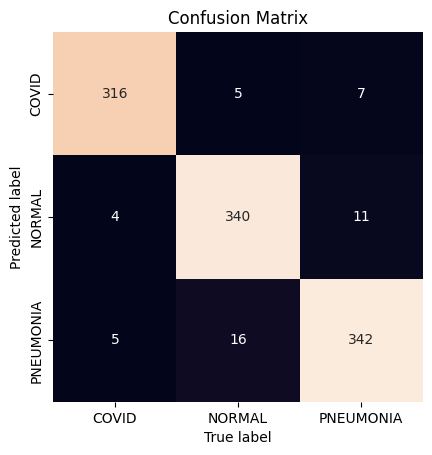

              precision    recall  f1-score   support

       COVID       0.96      0.97      0.97       325
      NORMAL       0.96      0.94      0.95       361
   PNEUMONIA       0.94      0.95      0.95       360

    accuracy                           0.95      1046
   macro avg       0.95      0.95      0.95      1046
weighted avg       0.95      0.95      0.95      1046



In [22]:
mat = confusion_matrix(ytest, yfit)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=categories, yticklabels=categories)

plt.xlabel('True label')
plt.ylabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(ytest, yfit, target_names=categories))

In [23]:
acc_svm = accuracy_score(ytest, yfit)
print("Accuracy:", acc_svm)

Accuracy: 0.9541108986615678


#Random Forest

In [24]:
model = RandomForestClassifier(random_state=42)
model.fit(Xtrain_scaled, ytrain)

yfit = model.predict(Xtest_scaled)

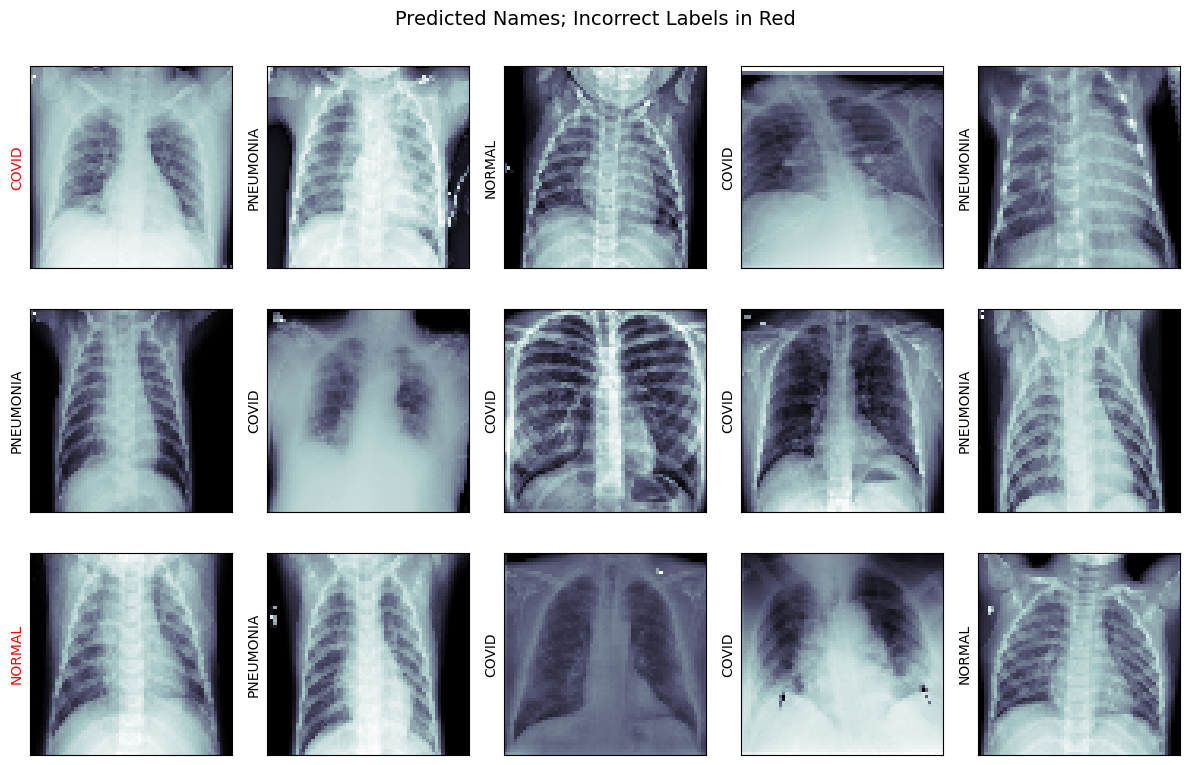

In [25]:
fig, ax = plt.subplots(3, 5, figsize=(12, 8))
for i, axi in enumerate(ax.flat):
    axi.imshow(Xtest[i].reshape(64, 64), cmap='bone')
    axi.set(xticks=[], yticks=[])
    axi.set_ylabel(categories[yfit[i]], color='black' if yfit[i] == ytest[i] else 'red')

fig.suptitle('Predicted Names; Incorrect Labels in Red', size=14)
plt.tight_layout()
plt.show()

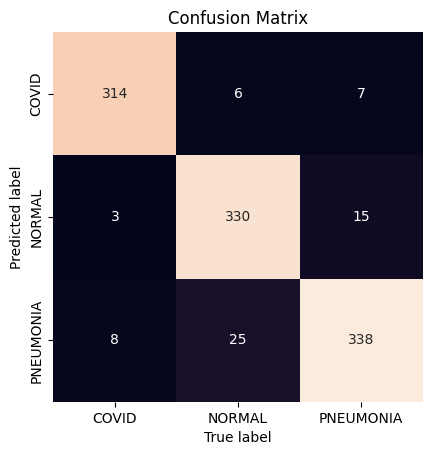

              precision    recall  f1-score   support

       COVID       0.96      0.97      0.96       325
      NORMAL       0.95      0.91      0.93       361
   PNEUMONIA       0.91      0.94      0.92       360

    accuracy                           0.94      1046
   macro avg       0.94      0.94      0.94      1046
weighted avg       0.94      0.94      0.94      1046



In [26]:
mat = confusion_matrix(ytest, yfit)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=categories, yticklabels=categories)

plt.xlabel('True label')
plt.ylabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(ytest, yfit, target_names=categories))

In [27]:
acc_rf = accuracy_score(ytest, yfit)
print("Accuracy:", acc_rf)

Accuracy: 0.9388145315487572


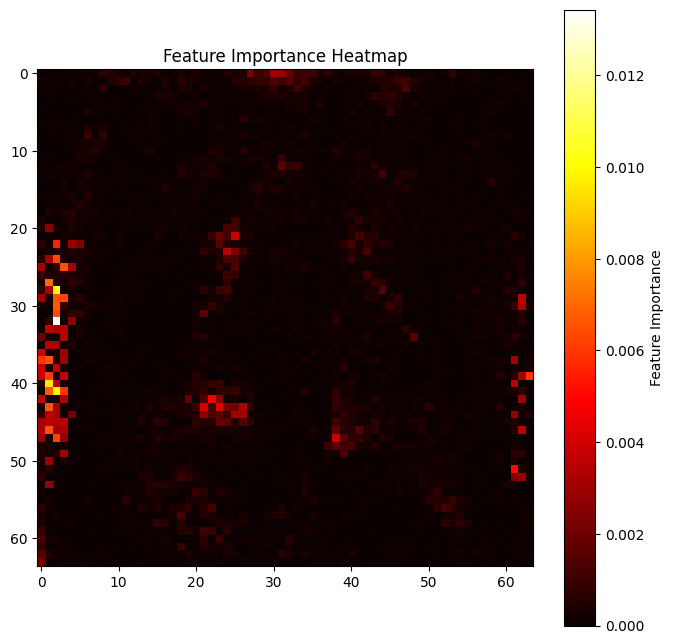

In [28]:
feature_importance = model.feature_importances_
importance_image = feature_importance.reshape(64, 64)

# Visualize the pixel importance as a heatmap
plt.figure(figsize=(8, 8))
plt.imshow(importance_image, cmap='hot', interpolation='nearest')
plt.title("Feature Importance Heatmap")
plt.colorbar(label="Feature Importance")
plt.show()

#Summary

In [29]:
df = {
    'Model': np.array(["SVM", "Random Forest", "Neural Network"]),
    'Accuracy': np.array([acc_svm, acc_rf, acc_nn])
    }
df = pd.DataFrame(df)

df

,Model,Accuracy
0,SVM,0.954111
1,Random Forest,0.938815
2,Neural Network,0.959847


#PCA

In [30]:
n_samples, height, width = x.shape
x_flat = x.reshape(n_samples, height * width)

scaler = StandardScaler()
x_scaled = scaler.fit_transform(x_flat)

(5228, 4096)
(5228, 150)


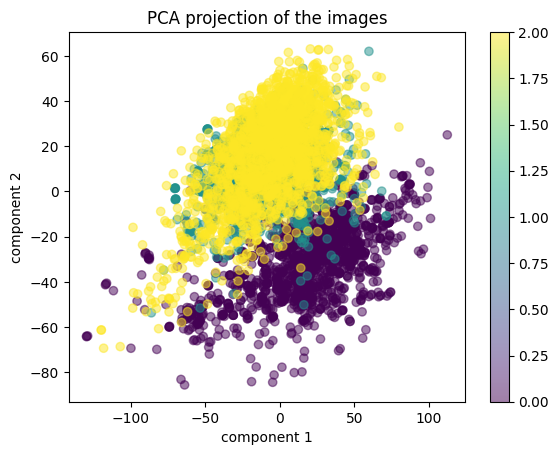

In [31]:
# PCA

# project from 4096 to 100 dimensions
pca = PCA(150)
components = pca.fit_transform(x_scaled)
print(x_scaled.shape)
print(components.shape)

# plot the first two principal components
plt.scatter(components[:, 0], components[:, 1], c=y, alpha=0.5)
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.title('PCA projection of the images')
plt.colorbar();
plt.show()

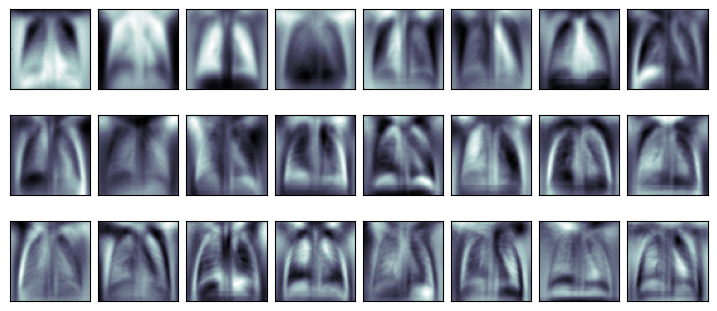

In [32]:
# the first components
fig, axes = plt.subplots(3, 8, figsize=(9, 4),
subplot_kw={'xticks':[], 'yticks':[]},
gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i, ax in enumerate(axes.flat):
  ax.imshow(pca.components_[i].reshape(64, 64), cmap='bone')
plt.show()